# Traduzioni orientate ai dati

In [ ]:
from urllib.request import urlopen
from IPython.display import HTML

from liblet import ANTLR, AnnotatedTreeWalker, Tree, Stack, warn

## Da JSON a tabella HTML

In [ ]:
# usiamo una grammatica "pronta"

with urlopen('https://raw.githubusercontent.com/antlr/grammars-v4/master/json/JSON.g4') as inf:
  grammar = inf.read().decode('utf-8')

JSON = ANTLR(grammar)

In [ ]:
JSON.print_grammar()

  1:	
  2:	/** Taken from "The Definitive ANTLR 4 Reference" by Terence Parr */
  3:	
  4:	// Derived from https://json.org
  5:	grammar JSON;
  6:	
  7:	json
  8:	   : value EOF
  9:	   ;
 10:	
 11:	obj
 12:	   : '{' pair (',' pair)* '}'
 13:	   | '{' '}'
 14:	   ;
 15:	
 16:	pair
 17:	   : STRING ':' value
 18:	   ;
 19:	
 20:	arr
 21:	   : '[' value (',' value)* ']'
 22:	   | '[' ']'
 23:	   ;
 24:	
 25:	value
 26:	   : STRING
 27:	   | NUMBER
 28:	   | obj
 29:	   | arr
 30:	   | 'true'
 31:	   | 'false'
 32:	   | 'null'
 33:	   ;
 34:	
 35:	
 36:	STRING
 37:	   : '"' (ESC | SAFECODEPOINT)* '"'
 38:	   ;
 39:	
 40:	
 41:	fragment ESC
 42:	   : '\\' (["\\/bfnrt] | UNICODE)
 43:	   ;
 44:	
 45:	
 46:	fragment UNICODE
 47:	   : 'u' HEX HEX HEX HEX
 48:	   ;
 49:	
 50:	
 51:	fragment HEX
 52:	   : [0-9a-fA-F]
 53:	   ;
 54:	
 55:	
 56:	fragment SAFECODEPOINT
 57:	   : ~ ["\\\u0000-\u001F]
 58:	   ;
 59:	
 60:	
 61:	NUMBER
 62:	   : '-'? INT ('.' [0-9] +)? EXP?
 63:	   ;
 64:	
 65:	
 66

### L'albero di parsing

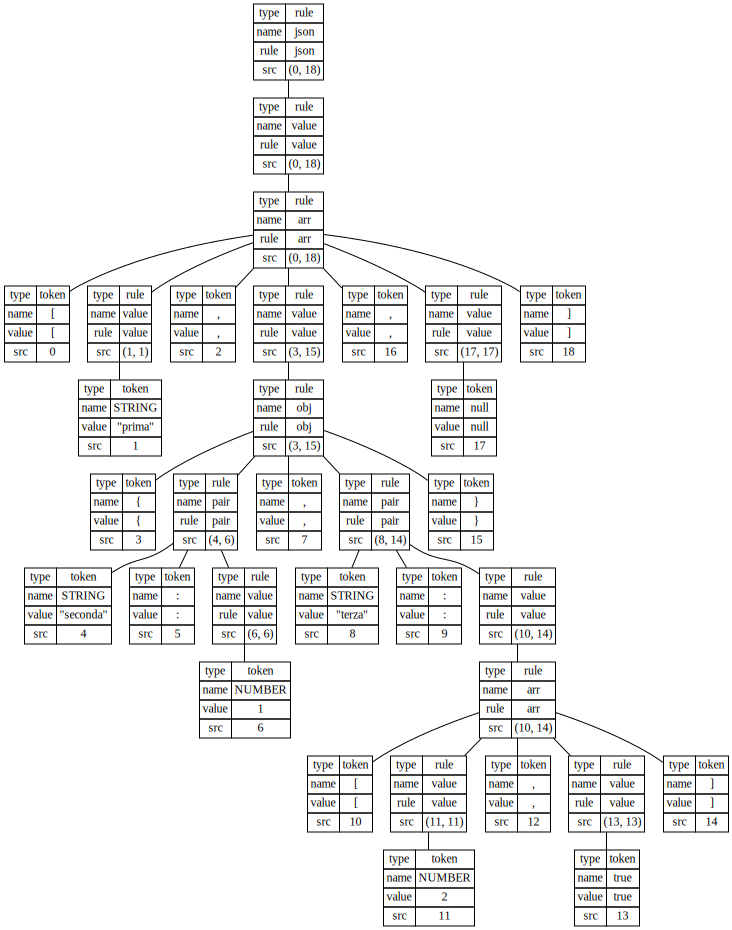

In [ ]:
json_source = """
[ "prima",
  {
    "seconda": 1, 
    "terza": [2, true]
  },
  null
]
"""
parse_tree = JSON.tree(json_source, 'json')
parse_tree

### Costruzione dell'AST

In [ ]:
jsonpt2ast = AnnotatedTreeWalker('name')

# un catchall meno "rumoroso"

@jsonpt2ast.catchall
def catchall(visit, tree):
  if tree.attr.type == 'token': return None
  return Tree(
    {'type': f'<{tree.attr.name}>'}, 
    filter(None, [visit(child) for child in tree.children])
  )

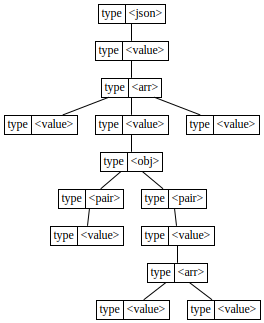

In [ ]:
jsonpt2ast(parse_tree)

In [ ]:
# i token 

@jsonpt2ast.register
def STRING(visit, tree):
  return Tree({'type': 'string', 'value': tree.attr.value[1:-1]})

@jsonpt2ast.register
def NUMBER(visit, tree):
  return Tree({'type': 'number', 'value': tree.attr.value})

@jsonpt2ast.register
def true(visit, tree):
  return Tree({'type': 'bool', 'value': True})

@jsonpt2ast.register
def false(visit, tree):
  return Tree({'type': 'bool', 'value': False})

@jsonpt2ast.register
def null(visit, tree):
  return Tree({'type': 'null'})

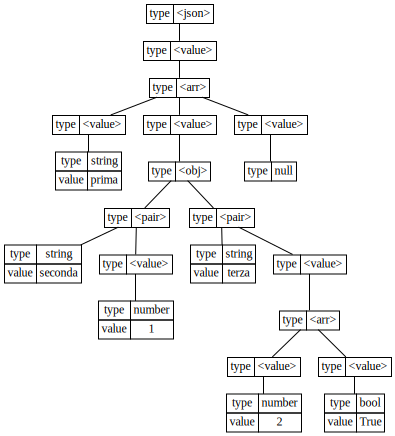

In [ ]:
jsonpt2ast(parse_tree)

In [ ]:
# le regole context-free

@jsonpt2ast.register
def value(visit, tree):
  child = tree.children[0]
  return visit(child)

@jsonpt2ast.register
def arr(visit, tree):
  values = tree.children[1::2] 
  return Tree({'type': 'arr'}, [visit(tree) for tree in values])

@jsonpt2ast.register
def pair(visit, tree):
  key, _, value = tree.children
  return Tree({'type': 'pair', 'key': key.attr.value[1:-1]}, [visit(value)])    

@jsonpt2ast.register
def obj(visit, tree):
  pairs = tree.children[1::2]
  return Tree({'type': 'obj'}, [visit(tree) for tree in pairs])

@jsonpt2ast.register
def json(visit, tree):
  return visit(tree.children[0])

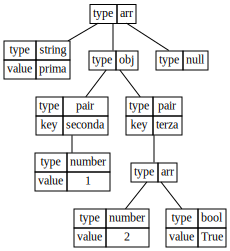

In [ ]:
ast = jsonpt2ast(parse_tree)
ast

### Dall'AST alla tabella HTML (solo con la ricorsione)

Usando la pila delle chiamate ricorsive.

In [ ]:
def jsonast2html(tree):
  node_type = tree.attr.type
  if node_type == 'bool':
    return '☑' if tree.attr.value else '☐'
  elif node_type == 'null':
    return '␀'
  elif node_type in ('string', 'number'):
    return tree.attr.value
  elif node_type == 'arr':
    values = [f'<tr><td>{jsonast2html(child)}</td></tr>' for child in tree.children]
    return '<table class="json">{}</table>'.format(''.join(values))
  elif node_type == 'pair':
    return f'<tr><th>{tree.attr.key}</th><td>{jsonast2html(tree.children[0])}</td></tr>'
  elif node_type == 'obj':
    pairs = [jsonast2html(child) for child in tree.children]
    return '<table class="json">{}</table>'.format(''.join(pairs))

In [ ]:
html = jsonast2html(jsonpt2ast(parse_tree))
html

'<table class="json"><tr><td>prima</td></tr><tr><td><table class="json"><tr><th>seconda</th><td>1</td></tr><tr><th>terza</th><td><table class="json"><tr><td>2</td></tr><tr><td>☑</td></tr></table></td></tr></table></td></tr><tr><td>␀</td></tr></table>'

In [ ]:
# un "trucco" di visualizzazione 

STYLE = """<style>
.json * {
    border: 1pt solid green !important; 
    text-align: left !important; 
    background: white;
}
</style>"""

HTML(STYLE + html)

# Da tabella HTML a *matrice*

In [ ]:
table = """
<table>
  <tr><td>1</td><td>2</td><td>3</td></tr>
  <tr><td>4</td><td>5</td><td>6</td></tr>
  <tr><td>7</td><td>8</td><td>9</td></tr>
  <tr><td>10</td><td>11</td><td>12</td></tr>
</table>
"""

In [ ]:
HTML(f'<div class=json>{table}</div>')

1,2,3
4,5,6
7,8,9
10,11,12


### Una grammatica elementare

Assumendo che negli elementi `td` ci possano essere altro che numeri interi.

In [ ]:
HtmlTable = ANTLR(r"""grammar HtmlTable;

table: '<table>' row+ '</table>' ;
row: '<tr>' col+ '</tr>' ;
col: '<td>' DATA '</td>' ;

DATA: '-'? [0-9]+ ;
WS: [ \t\n]+ -> skip ;
""")

### L'albero di parsing

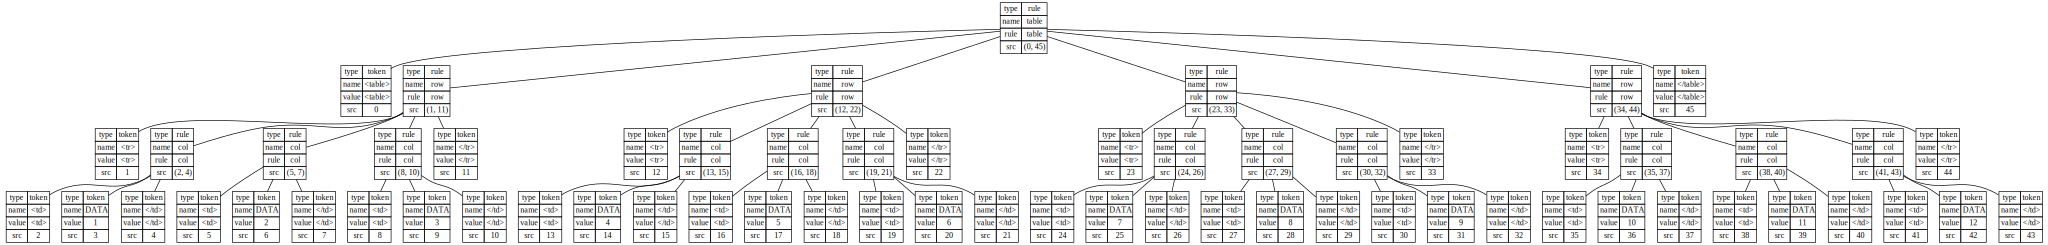

In [ ]:
parse_tree = HtmlTable.tree(table, 'table')
parse_tree

### Cosruzione dell'AST

In [ ]:
htmlpt2ast = AnnotatedTreeWalker('name')

@htmlpt2ast.register
def DATA(visit, tree):
  return Tree({'type': 'data', 'value': int(tree.attr.value)})

@htmlpt2ast.register
def row(visit, tree):
  cols = tree.children[1:-1] 
  return Tree({'type': 'row'}, [visit(tree.children[1]) for tree in cols])

@htmlpt2ast.register
def table(visit, tree):
  rows = tree.children[1:-1] 
  return Tree({'type': 'table'}, [visit(tree) for tree in rows])

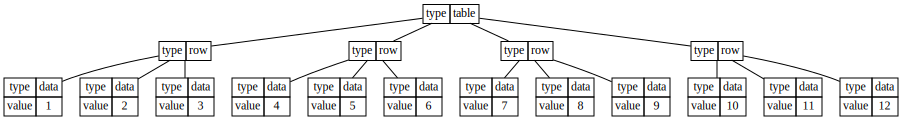

In [ ]:
ast = htmlpt2ast(parse_tree)
ast

### Dall'AST alla matrice

#### Usando una struttura dati esterna.

In [ ]:
STACK = Stack()

def htmlast2mat(ast):
  if ast.attr.type == 'data':
    STACK.push(ast.attr.value)
  elif ast.attr.type in {'row', 'table'}:
    for child in ast.children: htmlast2mat(child)
    vals = [STACK.pop() for _ in range(len(ast.children))]
    STACK.push(vals[::-1])

htmlast2mat(ast)
mat = STACK.pop()
mat

[[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]]

Per gioco, si può persino tornare all'HTML, visto che una matrice Python (come stringa) è JSON!

In [ ]:
json = str(mat)
json

'[[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]]'

In [ ]:
HTML(jsonast2html(jsonpt2ast(JSON.tree(json, 'json'))))

1
2
3
4
5
6
7
8
9
10
11


#### Decorando i nodi

In [ ]:
# aggiungere il numero di riga (attributo eredidato)

def add_rownum(ast, n):
  if ast.attr.type == 'table':
    for n, row in enumerate(ast.children): add_rownum(row, n)
    ast.attr.numrows = 1 + n
  elif ast.attr.type == 'row':
    ast.attr.row = n
    for col in ast.children: add_rownum(col, n)
  else:
    ast.attr.row = n

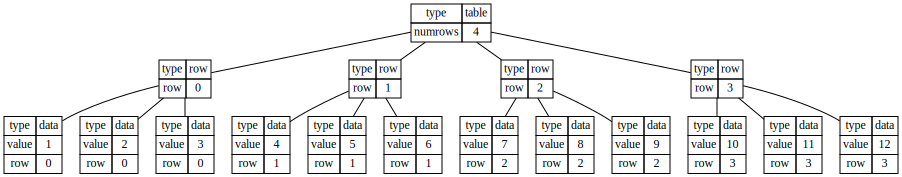

In [ ]:
ast = htmlpt2ast(parse_tree)        
add_rownum(ast, None)
ast

In [ ]:
# aggiungere il numero di colonna (attributo sintetizzato)
# verificando anche che tutte le righe abbiano lo stesso numero di colonne

def add_colnum(ast, n):
  if ast.attr.type == 'table':
    for row in ast.children: add_colnum(row, n)
    numcols = ast.children[0].attr.numcols
    for row in ast.children[1:]:
      if row.attr.numcols != numcols:
        if 'row' in row.root: # l'attributo row sarà presente solo dopo aver decorato con add_rownum
          warn(f'la riga {row.attr.row} ha {row.attr.numcols} colonne, non {numcols}')
        else:
          warn(f'una dele righe ha {row.attr.numcols} colonne, non {numcols}')
        return
    ast.attr.numcols = numcols
  elif ast.attr.type == 'row':
    for n, col in enumerate(ast.children): add_colnum(col, n)
    ast.attr.numcols = 1 + n
  else:
    ast.attr.col = n

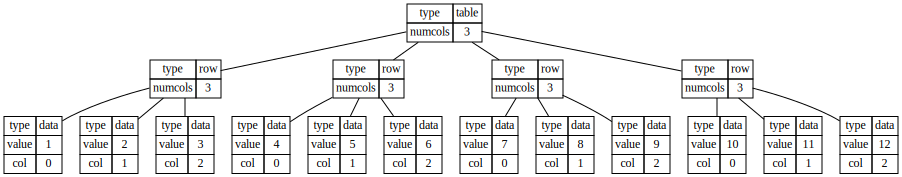

In [ ]:
ast = htmlpt2ast(parse_tree)
add_colnum(ast, None)
ast

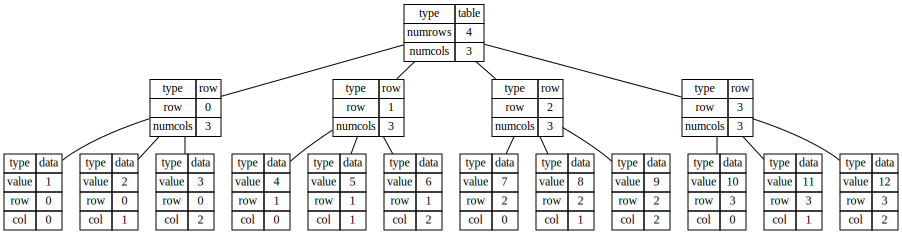

In [ ]:
# ora tutto assieme

ast = htmlpt2ast(parse_tree)     
add_rownum(ast, None)
add_colnum(ast, None)
ast

Avendo decorato i nodi, la costruzione della matrice è elementare

In [ ]:
numrows, numcols = ast.attr.numrows, ast.attr.numcols
mat = [[None for _ in range(numcols)] for _ in range(numrows)]
mat

[[None, None, None],
 [None, None, None],
 [None, None, None],
 [None, None, None]]

In [ ]:
# basta riempirla andando a caccia dei 'data'

def fill(ast):
  if ast.attr.type == 'data':
    mat[ast.attr.row][ast.attr.col] = ast.attr.value
  else:
    for c in ast.children: fill(c)

In [ ]:
fill(ast)
mat

[[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]]

## <span style="color: red;">Esercizi per casa</span> 

* La grammatica del formato JSON ammette sia oggetti che array vuoti,
  ma le funzioni di trasformazione (vesro l'AST e quindi l'HTML) 
  non sono scritte per funzionare in tale caso. Riuscite a correggerle?
  
* Come osservato, la grammatica per la tabella HTML non consente di mettere una 
  tabella dentro l'altra. Modificate la grammatica (e le funzioni
  di trasformazione ed estrazione della matrice) in modo che
  consentano di avere una tabella, o un numero, in ogni cella; in
  questo modo estrarrete una "matrice" alcuni dei quali elementi
  saranno a loro volta matrici (di interi).